
<a id='generic-programming'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Programação Genérica

## Conteúdos

- [Programação Genérica](#Programação-Genérica)  
  - [Visão Geral](#Visão-Geral)  
  - [Explorando Árvore de tipos](#Explorando-Árvore-de-Tipos)  
  - [Distribuições](#Distribuições)  
  - [Números e Estruturas Algébricas](#Números-e-Estruturas-Algébricas)  
  - [Estruturas Reais e Algébricas](#Estruturas-Reais-e-Algébricas)  
  - [Funções e Tipos de Funções](#Funções-e-Tipos-de-Funções)  
  - [Limitações de Expedição em Tipos Abstratos](#Limitações-de-Expedição-em-Tipos-Abstratos)  
  - [Exercícios](#Exercícios)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://quantecon.org/) pelos bolsistas CNPq, Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob supervisão do Prof. Christiano Penna, do CAEN/UFC.*

> Eu acho a POO (Programação Orientada a Objetos) metodologicamente errada. Começa com as aulas. É como se os matemáticos começassem com axiomas. Você não começa com axiomas - você começa com provas. Somente quando você encontrar várias provas relacionadas, poderá obter axiomas. Você termina com axiomas. O mesmo se aplica à programação: você precisa começar com algoritmos interessantes. Somente quando você os entende bem, você pode criar uma interface que permita que eles funcionem. - Alexander Stepanov

## Resumo

Nesta aula, nos aprofundamos mais na estrutura da linguagem Julia e, em particular:

- Tipos abstratos e concretos.  
- Os tipos de árvores.
- Projetando e usando interfaces genéricas.  
- O papel das interfaces genéricas no desempenho da linguagem Julia. 


Entendê-los irá ajudá-lo em:

- Formar um "modelo mental" em linguagem Julia. 
- Código de design que corresponde à matemática do "quadro branco". 
- Criar códigos que possa usar (e ser usado) por vários outros pacotes.
- Escrever código Julia "bem organizado", fácil de ler, modificar, manter e depurar.
- Melhorar a velocidade com que seu código é executado. 



(Agradecimento especial a Jeffrey Sarnoff)

### Programação genérica é uma atitude

De *Mathematics to Generic Programming* [[SR14]](https://lectures.quantecon.org/zreferences.html#stepanov-mathematics-2014)

>A programação genérica é uma abordagem de programação que se concentra no design de algoritmos e estruturas de dados, para que funcionem na configuração mais geral sem perda de eficiência ... A programação genérica é mais uma atitude em relação à programação do que um conjunto específico de ferramentas.

Nesse sentido, é importante pensar na programação genérica como uma abordagem interativa para descobrir a generalidade sem comprometer o desempenho, e não como um conjunto de regras.

Como veremos, a abordagem principal é tratar estruturas e algoritmos de dados como acoplados e contrastá-los diretamente com a    abordagem da programação orientada a objetos [is-a](https://en.wikipedia.org/wiki/Is-a).

Esta aula tem o duplo papel de apresentar uma introdução ao design de algoritmos genéricos e descrever como Julia ajuda a tornar isso possível.

### Configuração

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics
using Distributions, Plots, QuadGK, Polynomials, Interpolations

## Explorando Árvore de Tipos

A conexão entre as estruturas de dados a os algorítimos que operam nelas é tratado pelo sistema de tipos.


Tipos concretos (Isto é, `Float64` ou `Array{Float64, 2}`) são as estruturas de dados para a qual aplicamos um algorítimo, por sua vez, os tipos abstratos (por exemplo, `Number` e `AbstractArray`) providenciam o mapa entre um conjunto de estrutura de dados e algorítimos relatados.

In [3]:
using Distributions
x = 1
y = Normal()
z = "foo"
@show x, y, z
@show typeof(x), typeof(y), typeof(z)
@show supertype(typeof(x))

# pipe operator, |>, é equivalente
@show typeof(x) |> supertype
@show supertype(typeof(y))
@show typeof(z) |> supertype
@show typeof(x) <: Any;

(x, y, z) = (1, Normal{Float64}(μ=0.0, σ=1.0), "foo")
(typeof(x), typeof(y), typeof(z)) = (Int64, Normal{Float64}, String)
supertype(typeof(x)) = Signed
typeof(x) |> supertype = Signed
supertype(typeof(y)) = Distribution{Univariate,Continuous}
typeof(z) |> supertype = AbstractString
typeof(x) <: Any = true


Além das funções `typeof` e `supertype`, há outras ferramentas bastante úteis que são utilizadas para análise de árvore-tipos que são discutidas na [aula de introdução a tipos](https://lectures.quantecon.org/getting_started_julia/introduction_to_types.html).

In [4]:
using Base: show_supertypes # importe a função da `Base` package

show_supertypes(Int64)

Int64 <: Signed <: Integer <: Real <: Number <: Any

In [5]:
subtypes(Integer)

4-element Array{Any,1}:
 Bool                       
 GeometryTypes.OffsetInteger
 Signed                     
 Unsigned                   

Usando a função `subtypes`, nós podemos escrever um algorítimo para atravessar a árvore-tipo abaixo em qualquer tempo `t` – 
com a confiança de que todos tipos suportam `subtypes`.

In [6]:
#  a partir de https://github.com/JuliaLang/julia/issues/24741
function subtypetree(t, level=1, indent=4)
        if level == 1
            println(t)
        end
        for s in subtypes(t)
            println(join(fill(" ", level * indent)) * string(s))  # imprime o tipo
            subtypetree(s, level+1, indent)  # imprime recursivamente o próximo tipo, recuando
        end
    end

subtypetree (generic function with 3 methods)

Aplicando isso para `Number`, nós vemos a árvore de tipos carregada no momento.

In [7]:
subtypetree(Number) # atenção: não use essa função em ``Any``!

Number
    Complex
    Real
        AbstractFloat
            BigFloat
            Float16
            Float32
            Float64
        AbstractIrrational
            Irrational
        FixedPointNumbers.FixedPoint
            FixedPointNumbers.Fixed
            FixedPointNumbers.Normed
        Integer
            Bool
            GeometryTypes.OffsetInteger
            Signed
                BigInt
                Int128
                Int16
                Int32
                Int64
                Int8
            Unsigned
                UInt128
                UInt16
                UInt32
                UInt64
                UInt8
        Rational
        Ratios.SimpleRatio
        StatsBase.TestStat


Na maioria das vezes, todas as "saídas" serão do tipo concreto.

### Any

`Any` está na origem de todos os tipos.

Há algumas funções que funcionam em um contexto "mais generalizado": utilizáveis com qualquer coisa que você possa construir ou acessar de outros pacotes.

Nós já ativamos `typeof`, `show` e o `supertype` – que se aplicará a um tipo personalizado `struct` desde que `MyType <: Any`.

In [8]:
# tipo personalizado
struct MyType
    a::Float64
end

myval = MyType(2.0)
@show myval
@show typeof(myval)
@show supertype(typeof(myval))
@show typeof(myval) <: Any;

myval = MyType(2.0)
typeof(myval) = MyType
supertype(typeof(myval)) = Any
typeof(myval) <: Any = true


Vemos aqui outro exemplo de programação genérica: todo tipo `<: Any` suporta o grande `@show`, que por sua vez, conta com a função `show`.

O grande `@show` (1) retrata a expressão como um string; (2) estima a expressão; e (3) ativa a função `show` nos valores retornados.

Para ver isso com tipos internos.

In [9]:
x = [1, 2]
show(x)

[1, 2]

A função `Any` é bastante útil, pois ela fornece uma implementação de fallback para uma variedade de funções.

Portanto, ativar o `show` na nosso tipo personalizado despacha para a função fallback.

In [10]:
myval = MyType(2.0)
show(myval)

MyType(2.0)

A implementação padrão de fallback usada em Julia seria aproximandamente equivalente a:

```julia
function show(io::IO, x)
    str = string(x)
    print(io, str)
end
```


Para implementar uma implementação especializada de uma função `show` para o nosso tipo, em vez de usar este fallback:

In [11]:
import Base.show  # Para estender uma função existente

function show(io::IO, x::MyType)
    str = "(MyType.a = $(x.a))"  #  exibição personalizada
    print(io, str)
end
show(myval)  # cria um valor de IO primeiro e depois chama a função acima

(MyType.a = 2.0)

Neste ponto, nós podemos usar o `@show` , que por sua vez ativa o `show`.

In [12]:
@show myval;

myval = (MyType.a = 2.0)


Aqui nós vemos outro exemplo de programação genérica: qualquer tipo com uma função `show` funciona com `@show`.

Camadas de funções (por exemplo: `@show` ativando `show`) com uma implementação “fallback” possibilitam que novos tipos sejam projetados e especializados somente quando necessário.

### Desaprendendo Programação Orientada a Objetos- POO- (Avançado)

Veja [Types](https://docs.julialang.org/en/v1/manual/types/#man-types-1) Para mais informações sobre POO vs tipos genéricos.

Se você nunca usou linguagem de programação como a C++, Java ou Python; então as hierarquias de tipos acima podem parecer desconhacidas e abstratas.

Neste caso, mantenha a mente aberta para que essa discussão de conceitos abstratos tenha consequências práticas, mas não há necessidade de ler esta seção.

Por outro lado, se você já usou programação orientada a objetos nas linguagens citadas acima, então alguns dos conceitos abordados aqui serão familiares.

**Não se deixe enganar!**

A semelhança superficial pode conduzir ao mau uso: tipos *não* são classes com encapsulamento ruim, assim métodos *não* são equivalentes a funções-membro com a ordem dos argumentos trocados.

Em especial, conhecimento prévio em POO frequentemente conduz as pesssoas a escrever o código Julia como:

In [13]:
# Replicando um design POO em Julia
mutable struct MyModel
    a::Float64
    b::Float64
    algorithmcalculation::Float64

    MyModel(a, b) = new(a, b, 0.0) # Um construtor interno
end

function myalgorithm!(m::MyModel, x)
    m.algorithmcalculation = m.a + m.b + x # algum algoritmo
end

function set_a!(m::MyModel, a)
    m.a = a
end

m = MyModel(2.0, 3.0)
x = 0.1
set_a!(m, 4.1)
myalgorithm!(m, x)
@show m.algorithmcalculation;

m.algorithmcalculation = 7.199999999999999


Você pode achar que o código acima é similar ao POO, exceto que você:
* inverta o primeiro argumento, isto é, `myalgorithm!(m, x)` em vez de orientado a objetos `m.myalgorithm!(x)`.
* não possa controlar o encapsulamento dos campos`a`, `b`, mas pode adicionar um getter/setters como `set_a`.
* não tenha herança concreta.

Embora esse tipo de classificação seja possível, está faltando (verbalmente) o ponto de Julia e o do poder da programação genérica.

Quando programamos em Julia:

> - Não há [encapsulamento](https://en.wikipedia.org/wiki/Encapsulation_%28computer_programming%29) e a maioria dos tipos personalizados que foram criados são imutáveis.
- [Polimorfismo](https://en.wikipedia.org/wiki/Polymorphism_%28computer_science%29) é alcançado sem algo parecido com a  [Herança](https://en.wikipedia.org/wiki/Inheritance_%28object-oriented_programming%29) POO.
- [Abstração](https://en.wikipedia.org/wiki/Abstraction_%28computer_science%29#Abstraction_in_object_oriented_programming) é implementada mantendo os dados e algoritmos que operam neles o mais ortogonais possíveis - em contraste direto com a associação de algoritmos e métodos da POO diretamente a um tipo em uma árvore.
- Os supertipos em Julia são simplesmente usados para selecionar qual algoritmo especializado usar (ou seja, parte do polimorfismo genérico) e não têm nada a ver com a herança de POO.
- A folga que acompanha a manutenção de algoritmos e estruturas de dados o mais ortogonais possíveis facilita a descoberta de pontos em comum no design.

#### Design Interativo de  Abstrações

Em essência, a ideia do design de software genérico é que você começará criando algoritmo que são amplamente ortogonais a tipos concretos.

No decorrer do processo, você descobrirá semelhanças que levam a tipos abstratos com funções definidas informalmente operando nelas.

Dados os tipos abstratos e a semelhança, você refina os algoritmos, pois eles são mais limitados ou mais gerais do que você pensava inicialmente.

Esta abordagem é um contraste direto à análise e ao design orientado a objetos ([OOAD](https://en.wikipedia.org/wiki/Object-oriented_analysis_and_design))

Com isso, onde você especifica uma taxonomia de tipos, adiciona operações a esses tipos e depois desce para vários níveis de especialização (onde os algoritmos são incorporados em pontos da taxonomia e potencialmente especializados em herança).

Nos exemplos a seguir, mostraremos para exposição a hierarquia de tipos e os algoritmos que operam neles, mas a realidade é que os algoritmos geralmente são projetados primeiro e depois, os tipos abstratos.

## Distribuições

Primeiro, considere trabalhar com "distribuições".

Algoritmos usam distribuição para:
(1) desenhar números aleatórios para métodos de Monte-Carlo.
(2) calcular o pdf ou cdf - se estiver definido.

O processo de usar distribuições concretas nesses tipos de aplicações levou
para a criação do pacote [Distributions.jl](https://github.com/JuliaStats/Distributions.jl).

Vamos examinar as árvores de tipos de uma distribuição normal.

In [14]:
using Distributions
d1 = Normal(1.0, 2.0) # Um exemplo de tipo para explorar
@show d1
show_supertypes(typeof(d1))

d1 = Normal{Float64}(μ=1.0, σ=2.0)
Normal{Float64} <: Distribution{Univariate,Continuous} <: Sampleable{Univariate,Continuous} <: Any

O tipo `Sampleable{Univariate,Continuous}` tem um número limitado de funções, principalmente a capacidade de desenhar um número aleatório.

In [15]:
@show rand(d1);

rand(d1) = -3.0989701270433807


O propósito desse tipo abstrato é providenciar uma interface para desenhar uma variedade de distribuições, alguns dos quais podem não ter um *pdf* predefinido bem definido.
Se você estivesse escrevendo uma função para simular um processo estocástico com choques arbitrários
 iid, onde você não precisava assumir um *pdf* existente etc., este é um candidato natural.

Por exemplo, para simular $ x_{t+1} = a x_t + b \epsilon_{t+1} $ onde
$ \epsilon \sim D $ para qualquer $ D $, que permite desenhar valores aleatórios.

In [16]:
function simulateprocess(x₀; a = 1.0, b = 1.0, N = 5, d::Sampleable{Univariate,Continuous})
    x = zeros(typeof(x₀), N+1) # pré-alocar vetor, cuidado no tipo
    x[1] = x₀
    for t in 2:N+1
        x[t] = a * x[t-1] + b * rand(d) # extração
    end
    return x
end
@show simulateprocess(0.0, d=Normal(0.2, 2.0));

simulateprocess(0.0, d=Normal(0.2, 2.0)) = [0.0, -3.8322386309808074, -3.0794658530865155, -5.755563549658751, -3.339249853286089, -4.18044296266285]


Os tipo abstrato `Sampleable{Univariate,Continuous}` e, especialmente, o `Sampleable{Multivariate,Continuous}` são interfaces genéricas úteis para os métodos Monte-Carlo e Bayesiano.

Baixando a árvore, o tipo abstrato `Distributions{Univariate, Continuous}` tem outras funções que podemos usar para algoritmos genéricos que operam em distribuições.

Estes correspondem à matemática, tal como `pdf`, `cdf`, `quantile`, `support`, `minimum`, `maximum`, etc.

In [17]:
d1 = Normal(1.0, 2.0)
d2 = Exponential(0.1)
@show d1
@show d2
@show supertype(typeof(d1))
@show supertype(typeof(d2))

@show pdf(d1, 0.1)
@show pdf(d2, 0.1)
@show cdf(d1, 0.1)
@show cdf(d2, 0.1)
@show support(d1)
@show support(d2)
@show minimum(d1)
@show minimum(d2)
@show maximum(d1)
@show maximum(d2);

d1 = Normal{Float64}(μ=1.0, σ=2.0)
d2 = Exponential{Float64}(θ=0.1)
supertype(typeof(d1)) = Distribution{Univariate,Continuous}
supertype(typeof(d2)) = Distribution{Univariate,Continuous}
pdf(d1, 0.1) = 0.18026348123082397
pdf(d2, 0.1) = 3.6787944117144233
cdf(d1, 0.1) = 0.32635522028792
cdf(d2, 0.1) = 0.6321205588285577
support(d1) = RealInterval(-Inf, Inf)
support(d2) = RealInterval(0.0, Inf)
minimum(d1) = -Inf
minimum(d2) = 0.0
maximum(d1) = Inf
maximum(d2) = Inf


Você pode criar seu próprio tipo de Distribuição `Distributions{Univariate, Continuous}`  implementando essas funções – conforme descrito na [documentação](https://juliastats.github.io/Distributions.jl/latest/extends.html).

Se você atender a todas as condições de uma interface específica, poderá usar algoritmos do presente, passado e futuro escritos para o tipo abstrato  `Distributions{Univariate, Continuous}`.

Como um exmplo, considere o pacote [StatsPlots](https://github.com/JuliaPlots/StatsPlots.jl).

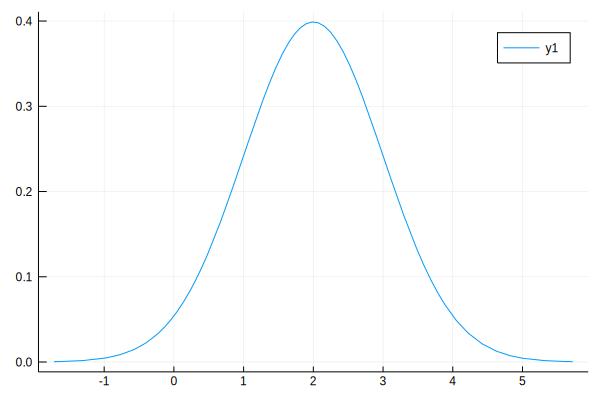

In [18]:
using StatsPlots
d = Normal(2.0, 1.0)
plot(d) # observe que não há outro argumento!

Ativando `plot` em qualquer subtipo de `Distributions{Univariate, Continuous}`
exibe o `pdf` e usa `minimum` e `maximum` para determinar o intervalo.

Vamos criar nosso próorio tipo de distribuição:

In [19]:
struct OurTruncatedExponential <: Distribution{Univariate,Continuous}
    α::Float64
    xmax::Float64
end
Distributions.pdf(d::OurTruncatedExponential, x) = d.α *exp(-d.α * x)/exp(-d.α * d.xmax)
Distributions.minimum(d::OurTruncatedExponential) = 0
Distributions.maximum(d::OurTruncatedExponential) = d.xmax
#  ...mais para ter um tipo completo

Para demonstrar isso:

In [20]:
d = OurTruncatedExponential(1.0,2.0)
@show minimum(d), maximum(d)
@show support(d) # por que isso funciona?

(minimum(d), maximum(d)) = (0, 2.0)
support(d) = RealInterval(0.0, 2.0)


RealInterval(0.0, 2.0)

Curiosamente, você notará que a função `support` funciona, mesmo que não tenhamos fornecido uma.

Este é outro exemplo do poder da exibição múltipla e da programação genérica.

Em segundo plano, o pacote `Distributions.jl` tem algo como o implementado a seguir:

```julia
    Distributions.support(d::Distribution) = RealInterval(minimum(d), maximum(d))
```


Como `OurTruncatedExponential <: Distribution`, e nós implementamos `minimum` e `maximum`, ativar `support` obtêm essa implementação como um fallback.

Estas funções são o suficiente para usarmos o pacote `StatsPlots.jl`. 

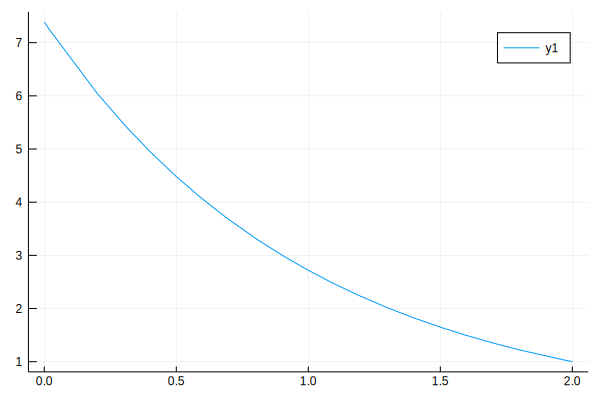

In [21]:
plot(d) # usa o código genérico!

Algumas coisas a destacar:

- Mesmo quando `StatsPlots` funcionar, nossa implementação está incompleta, pois não cumprimos todos os requisitos de uma `Distribution`.  
- Nós também não implementamos a função `rand`, que significa que estamos quebrando um contrato implícito do tipo abstrato
 `Sampleable`.
- Acontece que existe um jeito melhor de fazer isso extamente já incorporado à `Distributions`.

typeof(d) = Truncated{Exponential{Float64},Continuous}


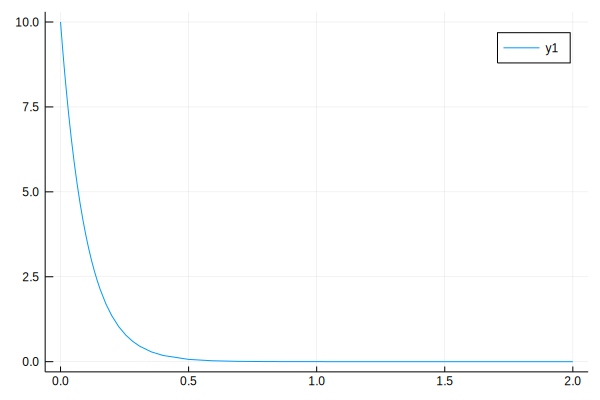

In [22]:
d = Truncated(Exponential(0.1), 0.0, 2.0)
@show typeof(d)
plot(d)

Este é o poder da programação genérica em geral, e em Julia em particular: você pode combinar e compor completamente pacotes e código separados, desde que haja um acordo sobre tipos e funções abstratas.

## Números e Estruturas Algébricas

Defina duas funções binárias,  $ + $ e $ \cdot $, chamadas adição e multiplicação – embora os operadores podem ser aplicados para estruturas de dados muito mais abstratas que um `Real`.

Na matemática, uma [ring](https://en.wikipedia.org/wiki/Ring_%28mathematics%29) é um conjunto com operadores de adição e multiplicação associados onde:

> - O operador de adição é associativo e comutativo .
- O operador de multiplicação é associativo e distributivo com relação ao operador de adição. 
- Há um elemento identidade aditivo,  denotado $ 0 $, tal que $ a + 0 = a $ para qualquer $ a $ no conjunto.  
- Há um inverso aditivo de cada elemento, denotado $ -a $, tal que $ a + (-a) = 0 $.  
- Há um elemento identidade multiplicativo, denotado $ 1 $, tal que $ a \cdot 1 = a = 1 \cdot a $.
- Uma ordenação total ou parcial **não** é requerida (isto é, não é necessário haver um operador $ < $ definido).  
- Um inverso multiplicativo **não** é requerido 



Enquanto isso pula algumas partes da definição matemática, essa estrutura algébrica fornece motivação para o tipo de `Número` abstrato em Julia:

> - **Observação:** Nós usamos o termo "motivação" por ele não ser formalmente conectado e ter um mapeamento imperfeito.
- A principal dificuldade ao se lidar com números que podem ser criados concretamente no computador é a não-garantia do requisito dos operadores estarem fechados no conjunto (ex.: pontos flutuantes tem números finitos de bits de informação).  



Seja `typeof(a) = typeof(b) = T <: Number`, então, sob uma definição informal de  **interface genérica** para
`Number`, o seguinte deve ser definido como:

> - o operador aditivo: `a + b`. 
- o operador multiplicativo: `a * b` . 
- um operador aditivo inverso: `-a`.  
- uma operação inversa para adição: `a - b = a + (-b)`.  
- uma identidade aditiva: `zero(T)` ou `zero(a)` por conveniência. 
- uma identidade multiplicativa: `one(T)` ou `one(a)` por conveniência. 



O núcleo da programação genérica é que, dado o conhecimento de que um valor é do tipo `Number`, podemos projetar qualquer uma dessas funções e não se preocupar com o tipo concreto em específico.

Além disso, tal generalidade no design de algorítimos não compromete o desempenho, ao ser comparado com algorítimos cuidadosamente desenhados, escritos para esse tipo em específico.

Para demonstrar isso para um número complexo, onde `Complex{Float64} <: Number`.

In [23]:
a = 1.0 + 1.0im
b = 0.0 + 2.0im
@show typeof(a)
@show typeof(a) <: Number
@show a + b
@show a * b
@show -a
@show a - b
@show zero(a)
@show one(a);

typeof(a) = Complex{Float64}
typeof(a) <: Number = true
a + b = 1.0 + 3.0im
a * b = -2.0 + 2.0im
-a = -1.0 - 1.0im
a - b = 1.0 - 1.0im
zero(a) = 0.0 + 0.0im
one(a) = 1.0 + 0.0im


E para um número inteiro de precisão arbitrária, onde `BigInt <: Number`
(i.e., um tipo diferente do que `Int64` você, ainda sim, trabalhou com `Number`).

In [24]:
a = BigInt(10)
b = BigInt(4)
@show typeof(a)
@show typeof(a) <: Number
@show a + b
@show a * b
@show -a
@show a - b
@show zero(a)
@show one(a);

typeof(a) = BigInt
typeof(a) <: Number = true
a + b = 14
a * b = 40
-a = -10
a - b = 6
zero(a) = 0
one(a) = 1


### Números Complexos e Composições de Funções Genéricas

Isso nos permite mostrar mais como se compõem os diferentes pacotes genéricos – ainda que eles estejam, ainda que fracamente, acoplados através de um acordo entre interfaces genéricas.

Os números `Complexos` requerem algum tipo de armazenamento por suas partes reais ou imaginárias subjacentes, que é deixado genérico.

Essa estrutura de dados é definida para trabalhos com algum `<: Number`, e é parametrizado (ex.: `Complex{Float64}` é um número complexo com partes reais e imaginárias armazenadas em `Float64`).

In [25]:
x = 4.0 + 1.0im
@show x, typeof(x)

xbig = BigFloat(4.0) + 1.0im
@show xbig, typeof(xbig);

(x, typeof(x)) = (4.0 + 1.0im, Complex{Float64})
(xbig, typeof(xbig)) = (4.0 + 1.0im, Complex{BigFloat})


A implementação dos números `Complexos` usa as operações subjacentes do que está armazenado; assim, desde que `+`, `*` etc. esteja definido como deve ser, para qualquer `número` – a operação complexa pode ser definida.

In [26]:
@which +(x,x)

+(z::Complex, w::Complex) in Base at complex.jl:271

Seguinte à este link, a implementação de `+` para números complexos é dada por:

```julia
+(z::Complex, w::Complex) = Complex(real(z) + real(w), imag(z) + imag(w))
```


`real(z)` e `imag(z)` retorna os componentes associados aos números complexos no armazenamento adjacente (ex.: `Float64` ou `BigFloat`).

O resto da função tem sido cuidadosamente escrito para o uso de funções definidas para qualquer `Number` (ex.: `+` mas não `<`, já que não faz parte da interface genérica do número).

Para o exemplo seguinte, procure a implementação de `abs`, especializada para números complexos.

In [27]:
@which abs(x)

abs(z::Complex) in Base at complex.jl:260

A fonte é:

```julia
abs(z::Complex)  = hypot(real(z), imag(z))
```


Nesse caso, se você procurar a função genérica para obter a hipotenusa, `hypot`, você vai ver que a função tem a assinatura `hypot(x::T, y::T) where T<:Number`, e trabalhos consequentes para qualquer `Number`.

Essa função, por sua vez, depende da subjacente `abs` no caso de `real(z)`.

Isso irá despachar os apropriados `abs` no devido caso.

In [28]:
@which abs(1.0)

abs(x::Float64) in Base at float.jl:528

In [29]:
@which abs(BigFloat(1.0))

abs(x::Real) in Base at number.jl:144

Com implementações:

```julia
abs(x::Real) = ifelse(signbit(x), -x, x)
abs(x::Float64) = abs_float(x)
```


Para um número `Real` (o que iremos discutir na próxima sessão), o recuo à implementação chama uma função `signbit` para determinar se se deve mudar o sinal do número.

A versão especializada para `Float64 <: Real` denomina uma função chamada `abs_float` – que acaba sendo uma implementação especializada no nível do compilador.

Embora nós não tenhamos dissecado completamente a árvore das funções, no fundo da ávore você irá encontrar a versão mais otimizada de funções com dados subjacentes.

Espero que isso mostre o poder da programação genérica: com um bem elaborado conjunto de tipos e funções abstratas, o código pode ser bastante usual e ter a mais eficiente implementação possível.

## Estruturas Reais e Algébricas

Voltando à motivação matemática, um [field](https://en.wikipedia.org/wiki/Field_%28mathematics%29) é um `ring` com algumas propriedades adicionais, dentre elas:

> - um multiplicador inverso: $ a^{-1} $  
- uma operação inversa para multiplicação: $ a / b = a \cdot b^{-1} $  



Além disso, nós faremos um [total ordered](https://en.wikipedia.org/wiki/Total_order#Strict_total_order) campo com:

> - um operador binário de pedido total: $ a < b $  



Esse tipo nos dá algumas motivações para o tipo `Real`.

E claro, `Complex{Float64} <: Number` mas não `Real` – desde que o pedido não esteja definido na matemática dos números complexos.

Essas operações são implementadas em qualquer subtipo `Real` através de:

> - da multiplicação inversa: `inv(a)`.
- da operação de multiplicação inversa: `a / b = a * inv(b)`.  
- do pedido `a < b`.  



Nós já mostramos estes com `Float64` e `BigFloat`.

Para mostrar isso nos números `Rational`, onde `a // b` constroem um número racional $ \frac{a}{b} $:

In [30]:
a = 1 // 10
b = 4 // 6
@show typeof(a)
@show typeof(a) <: Number
@show typeof(a) <: Real
@show inv(a)
@show a / b
@show a < b;

typeof(a) = Rational{Int64}
typeof(a) <: Number = true
typeof(a) <: Real = true
inv(a) = 10//1
a / b = 3//20
a < b = true


**Observação:** Aqui vemos onde e como a precisa conexão com a matemática cai por terra por razões práticas, particularmente:

> - Tipos de `Integer` (ex.: `Int64 <: Integer`) não tem uma inversa multiplicativa com fechamento no set;  
- Porém, é necessário na prática, para definir toda a divisão, e voltar ao conjunto dos números `Real`. 
- Isso é denominado [type promotion](https://docs.julialang.org/en/v1/manual/conversion-and-promotion/#Promotion-1), onde um tipo pode ser convertido em outro para garantir que uma operação seja possível pela conversão direta entre tipos (ou seja, independente da hierarquia de tipos).  



Não ache que a quebra na conexão entre as estruturas algébricas subjacentes e o código é uma falha no design.

Ao invés disso, os algorítimos subjacentes para computadores não encaixam perfeitamente as estruturas algébricas nessa instância.

Movendo-se mais para baixo, a árvore dos tipos provê mais operações diretamente ligadas à implementação computacional do que à álgebra.

Por exemplo, números de pontos flutuantes tem uma precisão de máquina, abaixo de quais números se tornam indistinguíveis à falta de “bits” de informação.

In [31]:
@show Float64 <: AbstractFloat
@show BigFloat <: AbstractFloat
@show eps(Float64)
@show eps(BigFloat);

Float64 <: AbstractFloat = true
BigFloat <: AbstractFloat = true
eps(Float64) = 2.220446049250313e-16
eps(BigFloat) = 1.727233711018888925077270372560079914223200072887256277004740694033718360632485e-77


A função `isless` tem métodos múltiplos.

Primeiro, vamos tentar com números inteiros:

In [32]:
@which isless(1, 2)

isless(x::Real, y::Real) in Base at operators.jl:346

Como vimos previamente, o tipo de dado `Real` é um tipo *abstrato*, e engloba ambos.

Se nós formos ao link fornecido na fonte, veremos que a função no seu todo é dada por:

```julia
isless(x::Real, y::Real) = x<y
```


Isto é, para quaisquer valores onde `typeof(x) <: Real` e `typeof(y) <: Real`, a definição depende de `<`.

Sabemos que `<` é definido pelos tipos por ser parte da interface informal para o tipo abstrato `Real`.

Note que isso não vale para `Number`, pois nem todos os tipos `Number` tem o `<` operador de pedidos definido (ou seja, `Complex`)

Para gerar um código rápido, os detalhes da implementação podem definir versões especializadas dessas operações.

In [33]:
isless(1.0, 2.0)  # aplicado a dois floats
@which isless(1.0, 2.0)

isless(x::Float64, y::Float64) in Base at float.jl:465

Note que o motivo pelo qual  `Float64 <: Real` é denominado de implementação ao invés do que foi dado acima, é que `Float64 <: Real`, e Julia escolhe sempre a implementação mais especializada para cada função.

Geralmente, as implementações especializadas são mais sutis do que você pode imaginar para o [floating point arithmetic](https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html), [underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow), etc.

## Funções e tipos de função

Outro exemplo comum da separação entre estrutura de dados e algorítimos é o uso de funções.

Sintaticamente, uma “função” univariada é qualquer `f` que tenha um argumento `x` como `f(x)`

Por exemplo, usaremos uma função comum:

quadgk(f, 0.0, 1.0) = (0.3333333333333333, 5.551115123125783e-17)


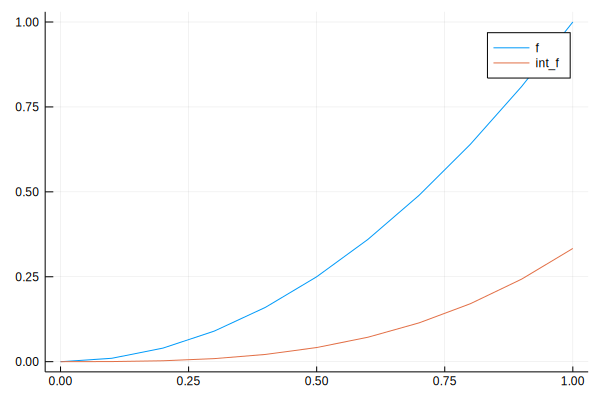

In [34]:
using QuadGK
f(x) = x^2
@show quadgk(f, 0.0, 1.0)  # integral

function plotfunctions(f)
    intf(x) = quadgk(f, 0.0, x)[1]  # int_0^x f(x) dx

    x = 0:0.1:1.0
    f_x = f.(x)
    plot(x, f_x, label="f")
    plot!(x, intf.(x), label="int_f")
end
plotfunctions(f)  # chame com o nosso f

Polinômios univariados, claro, são outra forma de função univariada:

p = Poly(2 - 5*x + 2*x^2)
p(1.0) = -1.0


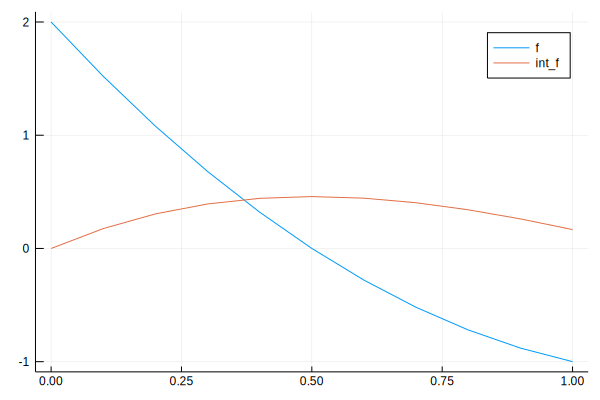

In [35]:
using Polynomials
p = Poly([2, -5, 2], :x)  # :x apenas fornece um símbolo para exibição
@show p
@show p(1.0) # chama como uma função

plotfunctions(p)  # alguma função genérica

Da mesma forma, o resultado dos dados interpolados é uma função:

f_int(1.0) = 1.0


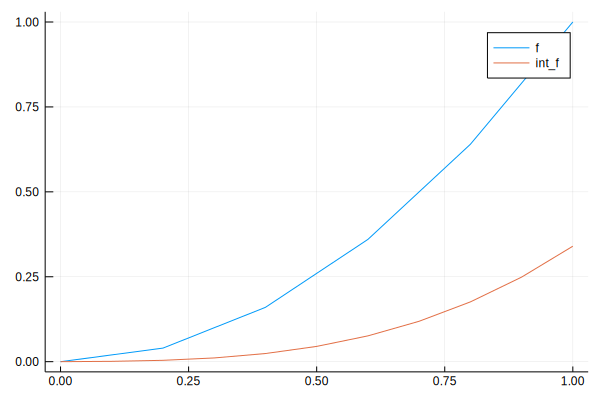

In [36]:
using Interpolations
x = 0.0:0.2:1.0
f(x) = x^2
f_int = LinearInterpolation(x, f.(x))  # interpola o grid
@show f_int(1.0)  # chama como uma função

plotfunctions(f_int)  # alguma função genérica

Perceba que o mesmo termo genérico `plotfunctions` poderia ser qualquer variável para que “parecesse” como uma função, podendo ser chamada de `f(x)`.

Essa aproximação ao design com tipos – termo genérico, mas sem declaração de algum tipo específico – é chamada de [duck typing](https://en.wikipedia.org/wiki/Duck_typing).

Caso você precise denominar algum tipo existente, veja [Function Like Objects](https://docs.julialang.org/en/v1/manual/methods/#Function-like-objects-1).

## Limitações de Expedição em Tipos Abstratos 

Você irá perceber que, no Julia, os tipos representam uma árvore com `Any` na raiz.

A estrutura da árvore trabalha bem para os exemplos acima, mas não nos permite associar categorizações múltiplas dos tipos.

Por exemplo, um tipo de semi-grupo seria útil na escrita do código genérico (ex:
soluções em tempo contínuo para as ODEs e métodos sem uso de matrizes), mas não pode ser implementado rigorosamente desde que o tipo `Matrix` seja um semi grupo como `AbstractArray`, mas nem todos os semi-grupos são `AbstractArray`.

A principal maneira para implementar isso em uma linguagem genérica é com um design aproximado chamado de “traits”.

- Veja a [discussão original](https://github.com/JuliaLang/julia/issues/2345#issuecomment-54537633) e um [exemplo de pacote para facilitar a padronização](https://github.com/mauro3/SimpleTraits.jl).  
- Uma descrição completa da padronização dos traços, bem como da evolução natural do Despacho Múltiplo, é dado nesse [blog post](https://white.ucc.asn.au/2018/10/03/Dispatch,-Traits-and-Metaprogramming-Over-Reflection.html).   

## Exercícios 

### Exercício 1a

Em um exercíco anterior, discutimos a [regra trapezoidal](https://julia.quantecon.org/../getting_started_julia/introduction_to_types.html#intro-types-ex-5) para uma integração numérica.

Para resumir, o vetor:

$$
\int_{\underline{x}}^{\bar{x}} f(x) \, dx \approx \omega \cdot \vec{f}
$$

onde $ \vec{f} \equiv \begin{bmatrix} f(x_1) & \ldots & f(x_N) \end{bmatrix}\in R^N $ e, para um espaçamento uniforme do grid de $ \Delta $,

$$
\omega \equiv \Delta \begin{bmatrix} \frac{1}{2} & 1 & \ldots & 1 & \frac{1}{2}\end{bmatrix} \in R^N
$$

A regra da quadratura pode ser implementada facilmente como:

In [37]:
using LinearAlgebra
function trap_weights(x)
    return step(x) * [0.5; ones(length(x) - 2); 0.5]
end
x = range(0.0, 1.0, length = 100)
ω = trap_weights(x)
f(x) = x^2
dot(f.(x), ω)

0.3333503384008434

Entretanto, neste caso, a criação do temporário `ω` é ineficiente, pois não há razões para alocar um vetor inteiro apenas
iterar através dele com o `ponto` . Em vez disso, crie um iterável seguindo a [definição de interface para Iteração](https://docs.julialang.org/en/v1/manual/interfaces/#man-interface-iteration-1), e
implemente o modificado `trap_weights` e integração.

Dica:  crie um tipo de modo que:

In [38]:
struct UniformTrapezoidal
    count::Int
    Δ::Float64
end

e então implemente a função `Base.iterate(S::UniformTrapezoidal, state=1)`.

### Exercíco 1b (Avançado)

Faça o tipo `UniformTrapezoidal` tipo operar como uma matriz com a [definição de interface para AbstractArray](https://docs.julialang.org/en/v1/manual/interfaces/#man-interface-array-1).  Com isso, você deveria poder ir `ω[2]` ou `length(ω)` para acessar os pesos em quadratura.

### Exercício 2 (Avançado)

Implemente os mesmos recursos do Exercício 1a e 1b, mas para a [regra trapezoidal não uniforme](https://en.wikipedia.org/wiki/Trapezoidal_rule#Non-uniform_grid).